# BERT - CRISPRoff


## BERT CRISPROff

Tutorial adapted from https://colab.research.google.com/github/antonio-f/BERT_from_scratch/blob/main/BERT_from_scratch.ipynb#scrollTo=qwf2L-wZFJo0

### 0. Useful links

https://datascience.stackexchange.com/questions/54412/how-to-add-a-cnn-layer-on-top-of-bert

### 1. Packages and Data

In [17]:
import os
import json

n_sequences = 10
kmer_length = 5


In [18]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 
import pprint
import requests

pp = pprint.PrettyPrinter()

Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)

b = []

for i in range (n_sequences):
    datas = requests.get('http://togows.org/api/ucsc/hg19/'+ str(Data['chromosome'][i])+':'+str(int(Data["Primary TSS, 5'"][i]-1000))+'-'+str(Data["Primary TSS, 5'"][i]+1000)).text.replace('\n','')    
    b.append(datas)

Promoter_sequences = pd.DataFrame(b)

def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

Promoter_sequences = Promoter_sequences.apply(lambda x: getKmers(x[0], kmer_length), axis = 1)
Promoter_sequences = pd.DataFrame(Promoter_sequences)

Promoters_text = list(Promoter_sequences[0])

for item in range(len(Promoter_sequences)):
    Promoters_text[item] = ' '.join(Promoter_sequences[0][item])

y_data = Promoter_sequences.iloc[:, 0].values     

Promoter_sequences[1] = Data.index[:(len(Promoter_sequences))]
Promoter_sequences.columns = [['sequence', 'index']]
Promoter_sequences['text'] = pd.DataFrame(Promoters_text)

#dataset = dict(pd.MultiIndex.from_frame(Promoter_sequences[['index','text']]))

In [10]:
from datasets import Dataset

datasets = Dataset.from_pandas(Promoter_sequences[['index','text']])
datasets

Dataset({
    features: ["('index',)", "('text',)"],
    num_rows: 10
})

### 2. Building a tokenizer

In [11]:
def dataset_to_text(dataset, output_filename="data.txt"):
  """Utility function to save dataset text to disk,
  useful for using the texts to train the tokenizer 
  (as the tokenizer accepts files)"""
  with open(output_filename, "w") as f:
    for t in dataset:
      print(t, file=f)

dataset_to_text(datasets, "train.txt")

In [34]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()

tokenizer.train(files='train.txt', 
                vocab_size=30_522,
                min_frequency=6,
                special_tokens=['<s>', '<pad>', '</s>', '<unk>', '<mask>']) 

In [36]:
import os 

os.mkdir('./liberto')
tokenizer.save_model('liberto')

['liberto/vocab.json', 'liberto/merges.txt']

### 3. Initializing the tokenizer

In [37]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('liberto',max_length = 3)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.


In [39]:
tokens = tokenizer('gcgc')
tokens.input_ids

[0, 277, 277, 2]

### 4. Preparing the data

In [40]:
batch = tokenizer( Promoters_text , max_length=10, padding='max_length', truncation=True)

In [41]:
import torch

labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])

In [43]:
labels

tensor([[   0,   88,  284,  261,  580,  584,  543,  861,  341,    2],
        [   0,  271,  305,  613,  541,  790,  414,  521,  432,    2],
        [   0,  262,  353,  431,  736,  761, 1220, 1110, 1217,    2],
        [   0,   88,   69,  312,  802, 1076,  866,  684,  512,    2],
        [   0,  284,  283,  422,  382,  392,  783,  492,  617,    2],
        [   0,  286,  271,  925, 1122,  511,  529,  526,  688,    2],
        [   0,   88,   71,  351,  427,  325,  288,  388, 1250,    2],
        [   0,  262,  285,  444,  494,  514,  493,  557,  426,    2],
        [   0,  287,  261, 1012,  681,  622,  517,  621, 1263,    2],
        [   0,  319,  262, 1286, 1030,  450,  892,  608,  537,    2]])

In [44]:
# make copy of labels tensor, this will be input_ids
input_ids = labels.detach().clone()
# create random array of floats with equal dims to input_ids
rand = torch.rand(input_ids.shape)
# mask random 15% where token is not 0 [PAD], 1 [CLS], or 2 [SEP]
# mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
mask_arr = (rand < .15) * (input_ids > 2) 
# loop through each row in input_ids tensor (cannot do in parallel)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3 

In [45]:
input_ids.shape

torch.Size([10, 10])

In [46]:
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels} 

In [47]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

In [48]:
dataset = Dataset(encodings) 

In [49]:
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True) 

### 5. Training the model

#### A. Initializing the model

In [50]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=30_522,  # we align this to the tokenizer vocab_size
    max_position_embeddings=514,
    hidden_size=768,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1
    ) 

In [51]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config) 

#### B. Training Preparation

In [52]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device) 

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [53]:
from transformers import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-4)

/Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### C. Training 

In [54]:
from tqdm import tqdm

epochs = 2

for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optim.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item()) 

Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, loss=8.85]


In [55]:
model.save_pretrained('./liberto')  # and don't forget to save liBERTo!

### 6. The real test

In [31]:
from transformers import pipeline

In [32]:
# Creates file too large for github to sync
#fill = pipeline('fill-mask', model='liberto', tokenizer='liberto')

In [56]:
fill(f'gcgc {fill.tokenizer.mask_token} tata ')

[{'score': 0.0016671427292749286,
  'token': 0,
  'token_str': '<s>',
  'sequence': 'gcgc tata '},
 {'score': 0.00134976115077734,
  'token': 2,
  'token_str': '</s>',
  'sequence': 'gcgc tata '},
 {'score': 0.00031376106198877096,
  'token': 262,
  'token_str': 'aa',
  'sequence': 'gcgcaa tata '},
 {'score': 0.00026194300153292716,
  'token': 15426,
  'token_str': '',
  'sequence': 'gcgc tata '},
 {'score': 0.00023920593957882375,
  'token': 11941,
  'token_str': '',
  'sequence': 'gcgc tata '}]

In [71]:
# To do: Fork ENFORMER from Deepmind repo and adapt it to include methylation information

In [61]:
import pysam
import pandas as pd

In [88]:
save = pysam.set_verbosity(0)
samfile = pysam.AlignmentFile("/Users/sergiomares/Downloads/293T1_sorted.bam", "rb")
a = 0
b = []


for read in samfile:
    if a != 50:
        print(read)
        a += 1



HS1:329:C3EGUACXX:5:2107:3073:68585	256	#0	10065	1	50M	*	0	0	CCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACACA	array('B', [34, 34, 34, 37, 37, 37, 37, 37, 39, 39, 38, 39, 39, 41, 41, 40, 41, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 40, 40, 40, 40, 41, 41, 41, 41, 41, 40, 41, 41, 41, 41, 41, 40, 40, 41, 41, 41, 41, 41])	[('AS', -12), ('XN', 0), ('XM', 2), ('XO', 0), ('XG', 0), ('NM', 2), ('MD', '47C1T0'), ('YT', 'UU'), ('NH', 4), ('CC', 'chr10'), ('CP', 135524461), ('HI', 0)]
HS1:329:C3EGUACXX:5:2312:18115:5456	272	#0	10532	0	50M	*	0	0	ACAGTACCACCGAAATCTGTGCAGAGGAGAACGCAGCTCCGCCCTCGCGG	array('B', [36, 35, 35, 35, 35, 33, 35, 33, 32, 35, 36, 37, 37, 37, 37, 37, 37, 39, 39, 37, 39, 39, 41, 41, 41, 41, 41, 41, 41, 41, 40, 41, 41, 41, 41, 41, 41, 39, 39, 39, 39, 39, 37, 37, 37, 37, 37, 34, 34, 34])	[('AS', -11), ('XN', 0), ('XM', 2), ('XO', 0), ('XG', 0), ('NM', 2), ('MD', '1G26C21'), ('YT', 'UU'), ('NH', 7), ('CC', 'chr12'), ('CP', 95042), ('HI', 0)]
HS1:329:C3EGUACXX:5:1212:12394:8998

In [25]:
len('CCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCAACACA')

counts = [34, 34, 34, 37, 37, 37, 37, 37, 39, 39, 38, 39, 39, 41, 41, 40, 41, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 40, 40, 40, 40, 41, 41, 41, 41, 41, 40, 41, 41, 41, 41, 41, 40, 40, 41, 41, 41, 41, 41]

In [91]:
import torch 
import torch.nn as nn 

layers = []

layers.append(nn.Linear(3,4))
layers.append(nn.Sigmoid())
layers.append(nn.Linear(4,1))
layers.append(nn.Sigmoid())

net = nn.Sequential(*layers)

print(net)



Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=4, out_features=1, bias=True)
  (3): Sigmoid()
)


## Spatial Transformer networks tutorial

Adapted from https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html

In this tutorial, you will learn how to augment your network using a visual attention mechanism called spatial transformer networks. You can read more about the spatial transformer networks in the DeepMind paper

Spatial transformer networks are a generalization of differentiable attention to any spatial transformation. Spatial transformer networks (STN for short) allow a neural network to learn how to perform spatial transformations on the input image in order to enhance the geometric invariance of the model. For example, it can crop a region of interest, scale and correct the orientation of an image. It can be a useful mechanism because CNNs are not invariant to rotation and scale and more general affine transformations.

One of the best things about STN is the ability to simply plug it into any existing CNN with very little modification.

In [95]:
# License: BSD
# Author: Ghassen Hamrouni

from IPython.display import Image

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

Loading the data

In this post we experiment with the classic MNIST dataset. Using a standard convolutional network augmented with a spatial transformer network.

In [96]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 26192154.98it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 141419.34it/s]           
1654784it [00:00, 21560692.33it/s]
8192it [00:00, 288521.51it/s]
/Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-wdh4qigd/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Depicting spatial transformer networks

Spatial transformer networks boils down to three main components :

The localization network is a regular CNN which regresses the transformation parameters. The transformation is never learned explicitly from this dataset, instead the network learns automatically the spatial transformations that enhances the global accuracy.
The grid generator generates a grid of coordinates in the input image corresponding to each pixel from the output image.
The sampler uses the parameters of the transformation and applies it to the input image.

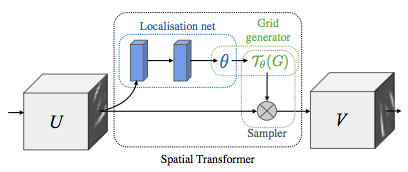

In [99]:
Image("https://pytorch.org/tutorials/_images/stn-arch.png")

In [100]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

### Training the model

Now, let’s use the SGD algorithm to train the model. The network is learning the classification task in a supervised way. In the same time the model is learning STN automatically in an end-to-end fashion.

In [102]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

### Visualizing the STN results

Now, we will inspect the results of our learned visual attention mechanism.

We define a small helper function in order to visualize the transformations while training.

In [103]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

/Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/torch/nn/functional.py:3887: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/torch/nn/functional.py:3825: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.356545
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.790669


/Users/sergiomares/miniconda3/envs/tf/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1920, Accuracy: 9457/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.494004
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.239486

Test set: Average loss: 0.1874, Accuracy: 9434/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.399097
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.441394

Test set: Average loss: 0.0852, Accuracy: 9744/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.164118
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.418874

Test set: Average loss: 0.5096, Accuracy: 8405/10000 (84%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.252654


KeyboardInterrupt: 

## CoAtNet: how to perfectly combine CNNs and Transformers

Adapted from https://medium.com/codex/coatnet-how-to-perfectly-combine-cnns-and-transformer-9632e187ecbf


### 1. Introduction 



On September 15, 2021, a new architecture defined the state-of-the-art (SOTA) in the ImageNet competition. CoAtNet (pronounced “coat” net) achieved a 90.88% top-1 accuracy with the huge JFT-3B dataset. More importantly, CoAtNet, when pre-trained with the (relatively) poor dataset ImageNet-21K (13M images), reached a top-1 accuracy of 88.56%.
The “coat” in CoAtNet is derived from Convolution and Self-Attention. I have struggled to figure out what this coat might allegorically represent, but have yet to find a solution. It is a very cozy acronym, though.
CoAtNet takes advantage of the super-powers of both Convolutional Neural Networks (CNNs) and Transformers, which we will discuss broadly later: Translation Equivariance, Input-adaptive Weighting, and Global Receptive Field. These three qualities are fused together to build a powerful new family of architectures, based on the MBConv block and relative self-attention.

The “coat” in CoAtNet is derived from Convolution and Self-Attention. I have struggled to figure out what this coat might allegorically represent, but have yet to find a solution. It is a very cozy acronym, though.

CoAtNet takes advantage of the super-powers of both Convolutional Neural Networks (CNNs) and Transformers, which we will discuss broadly later: **Translation Equivariance, Input-adaptive Weighting, and Global Receptive Field.** These three qualities are fused together to build a powerful new family of architectures, based on the MBConv block and relative self-attention.

___

### 2. A brief introduction to Convolution, to understand Depthwise Separable Convolution, to define the MBConv block (finally)

Before delving into the architecture of CoAtNet, it is necessary to give a brief introduction to CNNs. CNNs emerged from the study of the brain’s visual cortex in the 1980s, carried out by the two Nobel prizes David Hubel and Torsten Wiesel. These two scientists showed that neurons have a small local receptive field, so they only react to a particular area of the visual field, and these different areas may overlap. Moreover, they noticed that some neurons react only in relation to a specific pattern (i.e. horizontal lines) and that some neurons react to specific complex patterns, which are a combination of low-level patterns. Inspired by these ideas, in 1998, Yann LeCun introduced the LeNet architecture, which leverages convolutional and pooling layers for the first time. After a few years of silence, CNNs hit back with AlexNet, outperforming the results in the ImageNet competition. This spectacular comeback was made possible by the increase in computational power and the amount of available data, that occurred continuously during those years. After this event, a large slice of Computer Vision research shifted to CNNs and several networks were introduced over the years, such as VGG, ResNet, Inception, EfficientNet, MobileNet, and so on.
As just mentioned, one of the two fundamental blocks of CNNs is convolutional layers. In convolutional layers, neurons are not connected to every pixel in the input image, but only to pixels in their receptive field. During training, learnable filters or kernels, which are convoluted over the image, are used. Each filter learns to recognize specific patterns, and low-level filters are related to more complex patterns. Given a 224×224×3 RGB image, you can imagine using a convolutional layer with n filters 3×3×3. This means sliding each of the n filters over the images and performing the convolution operation, as shown in the figure below. The results of the convolutions are stacked together to form a Hₒᵤₜ × Wₒᵤₜ × n output. The width Wₒᵤₜ and the height Hₒᵤₜ of the output depend on the kernel size and on the values of stride (how large the kernel step is as it moves across the image) and padding (how the borders of the images are treated). These concepts are not covered in this brief introduction, an extensive explanation of CNNs can be found here.


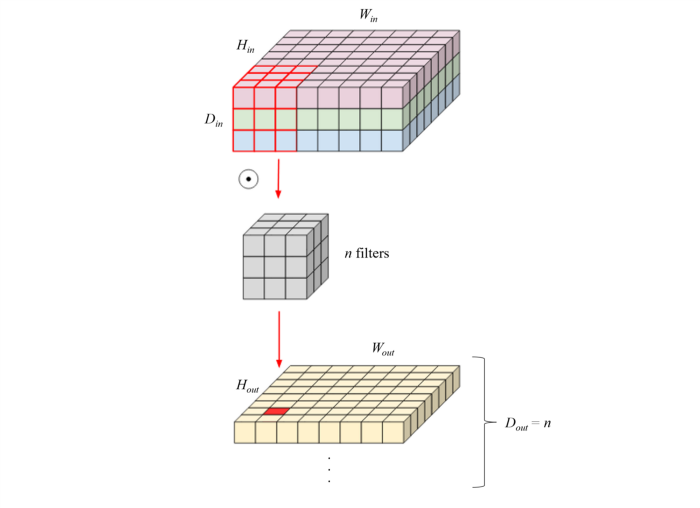

In [115]:
Image("https://miro.medium.com/max/700/1*EIWOM82R5Xna_LLBQTSi8g.png")

### 3. CoAtNet

Code adapted from https://github.com/chinhsuanwu/coatnet-pytorch

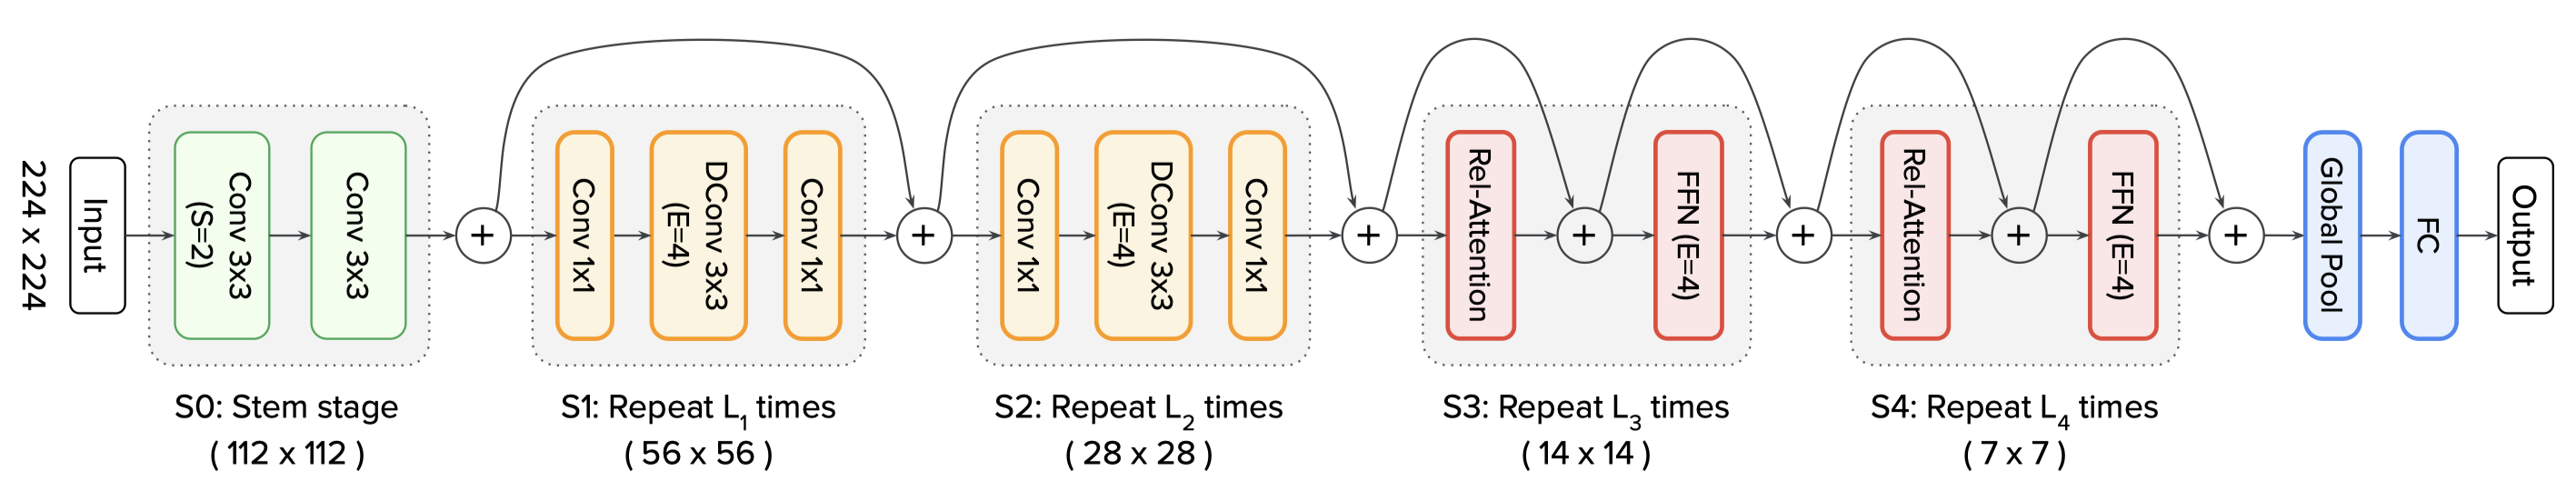

In [114]:
Image("https://user-images.githubusercontent.com/67839539/138133065-337bb5ac-3dca-4ce8-af51-990c5ff23316.png")

In [87]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Rearrange

## Block of 2D convolutional layer, maybe change this to one?

def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

## FeedForward layer

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


## The merging convolution and self attention

class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)

## The attention module

class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


## The famous transformer

class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x


## Joining everything together

class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)


def coatnet_0():
    num_blocks = [2, 2, 3, 5, 2]            # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_1():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_2():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [128, 128, 256, 512, 1026]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_3():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_4():
    num_blocks = [2, 2, 12, 28, 2]          # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == '__main__':
    img = torch.randn(1, 3, 224, 224)

    net = coatnet_0()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_1()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_2()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_3()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_4()
    out = net(img)
    print(out.shape, count_parameters(net))

torch.Size([1, 1000]) 17789624
torch.Size([1, 1000]) 33170624
torch.Size([1, 1000]) 55767564
torch.Size([1, 1000]) 117724480
torch.Size([1, 1000]) 203960368


In [201]:

num_blocks = [2, 2, 3, 5, 2]            # L
channels = [1,1,1,1]      # D
block_types=['C', 'T', 'T', 'T']        # 'C' for MBConv, 'T' for Transformer

net = CoAtNet((2501,4), 3, num_blocks, channels, block_types=block_types)
out = net(img)

ZeroDivisionError: float division by zero

## Example Data


In [89]:
import torch

img = torch.randn(1, 3, 224, 224)
net = coatnet_0()
out = net(img)

In [108]:
img.shape

torch.Size([1, 3, 224, 224])

In [106]:
num_blocks = [2, 2, 3, 5, 2]            # L
channels = [64, 96, 192, 384, 768]      # D
block_types=['C', 'T', 'T', 'T']        # 'C' for MBConv, 'T' for Transformer

net = CoAtNet((224, 224), 3, num_blocks, channels, block_types=block_types)
out = net(img)

## Obtain the one hot coding sequence data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Data = pd.read_csv('/Users/sergiomares/The_table.txt',sep = ' ',  header = None)
Cpg_Islands = pd.read_csv('/Users/sergiomares/Enero162022/coordiantes.txt', header = 0, sep= '\t' )

from math import sqrt

Data.columns = ['Gene','CRISPRoff_average','mutant_average','NaN','Sequence']

for i in range(len(Data)):

    if Data['mutant_average'][i] > Data['CRISPRoff_average'][i]:
        Data.at[i, 'Phe_sco_pos_neg'] =  int(1)
        Data.at[i,'Strength'] =  sqrt(abs(Data['mutant_average'][i] - Data['CRISPRoff_average'][i])) 

    elif Data['mutant_average'][i] < Data['CRISPRoff_average'][i]:
        Data.at[i, 'Phe_sco_pos_neg'] = int(0)
        Data.at[i,'Strength'] = 0
    else:
        Data.at[i, 'Strength'] = 'Same'

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

sequences = Data['Sequence'][:]

 # This removes empty sequences.

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

counter = 0 
for sequence in sequences:
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 AAATATATTT ... GAATAACTCT
One hot encoding of Sequence #1:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


In [3]:
gb = input_features
gb.shape

(18694, 2501, 4)

In [4]:
gb = gb[..., None]
gb.shape

(18694, 2501, 4, 1)

In [5]:
import random 

a = [0,1]

while(len(a) != 2501):
    a.append(int(random.random()+0.5))
a

[0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,


In [16]:
a[0]

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0,1,0,1,1,0,0,0,1,1,...,1,1,0,0,1,1,0,1,0,1


In [29]:
Promoter_sequences = Promoter_sequences.reset_index()

In [45]:
for i, x in enumerate(pd.DataFrame(Promoter_sequences['text'])):
    print(i, x)

0 ('text',)


In [142]:
Cgs = pd.read_csv('/Users/sergiomares/Desktop/Escritorio - MacBook Air de Sergio/Cpgs-ucsc.txt', delim_whitespace= True)
Cgs

,#bin,chrom,chromStart,chromEnd,name,length,cpgNum,gcNum,perCpg,perGc,obsExp
27,chr1,155188536,155192004,CpG:,361,3468,361,2761,20.8,79.6,0.73
75,chr1,2226773,2229734,CpG:,366,2961,366,1999,24.7,67.5,1.08
107,chr1,36306229,36307408,CpG:,110,1179,110,824,18.7,69.9,0.77
118,chr1,47708822,47710847,CpG:,164,2025,164,1268,16.2,62.6,0.83
124,chr1,53737729,53739637,CpG:,221,1908,221,1347,23.2,70.6,0.93
...,...,...,...,...,...,...,...,...,...,...,...
73,chr22_KI270734v1_random,131009,132049,CpG:,102,1040,102,682,19.6,65.6,0.91
586,chr22_KI270734v1_random,161256,161626,CpG:,55,370,55,288,29.7,77.8,0.98
585,chr22_KI270735v1_random,17220,18098,CpG:,100,878,100,600,22.8,68.3,1.01
585,chr22_KI270738v1_random,4412,5280,CpG:,80,868,80,586,18.4,67.5,0.81


In [146]:
min(Cgs['length'])

201